20.07.2019 al 31.07.2019

In [1]:
import pandas as pd
import tools
from datetime import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import keras
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error

In [2]:
df_1 = pd.read_csv(r'..\data\untouched_data\oli\2018\HPDIC059.csv', sep=';')
df_2 = pd.read_csv(r'..\data\untouched_data\oli\2018\HPI884.csv', sep=';')
df_3 = pd.read_csv(r'..\data\untouched_data\oli\2018\HTI878.csv', sep=';')
df_4 = pd.read_csv(r'..\data\untouched_data\oli\2018\HTI893.csv', sep=';')
df_1['Time'] = pd.to_datetime(df_1['Time'], format=tools.date_format)
df_2['Time'] = pd.to_datetime(df_2['Time'], format=tools.date_format)
df_3['Time'] = pd.to_datetime(df_3['Time'], format=tools.date_format)
df_4['Time'] = pd.to_datetime(df_4['Time'], format=tools.date_format)
splits = ['01/06/2019','01/07/2019','01/08/2019']
d_1 = datetime.strptime(splits[0], "%d/%m/%Y")
d_2 = datetime.strptime(splits[2], "%d/%m/%Y")
df_1 = df_1.set_index('Time').sort_index()[d_1:d_2]
df_2 = df_2.set_index('Time').sort_index()[d_1:d_2]
df_3 = df_3.set_index('Time').sort_index()[d_1:d_2]
df_4 = df_4.set_index('Time').sort_index()[d_1:d_2]

In [3]:
df_1.index.name

'Time'

<AxesSubplot:xlabel='Time'>

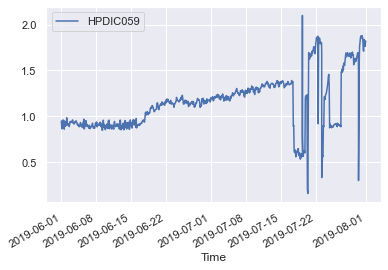

In [4]:
df_1.plot()

In [5]:
#df_1 = df_1.reset_index().head()
#df_1.head()

For example, to begin, i'll start doing a test with df_1

In [6]:
train_size = int(len(df_1)*0.95)
test_size = len(df_1) - train_size
train, test = df_1.iloc[0:train_size], df_1.iloc[train_size:len(df_1)]
print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (703, 1)
Test shape (38, 1)


In [7]:
train.head()

,HPDIC059
Time,
2019-06-01 00:57:07,0.946
2019-06-01 02:56:59,0.895
2019-06-01 04:56:51,0.862
2019-06-01 06:56:43,0.958
2019-06-01 08:56:35,0.902


In [8]:
from sklearn.preprocessing import RobustScaler
# data standardization
robust = RobustScaler(quantile_range=(25,75)).fit(train[['HPDIC059']])
train['HPDIC059'] = robust.transform(train[['HPDIC059']])
test['HPDIC059'] = robust.transform(test[['HPDIC059']])

ipykernel_launcher:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# helper function
def create_dataset(X, y, time_steps=1):
  a, b = [], []
  for i in range(len(X) - time_steps):
     v = X.iloc[i:(i + time_steps)].values
     a.append(v)
     b.append(y.iloc[i + time_steps])
  return np.array(a), np.array(b)

In [10]:
# We'll create sequences with 30 days of historical data
n_steps = 30
 # Reshape to 3D [n_samples, n_steps, n_features]

X_train, y_train = create_dataset(train[['HPDIC059']], train['HPDIC059'], n_steps)
X_test, y_test = create_dataset(test[['HPDIC059']], test['HPDIC059'], n_steps)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (673, 30, 1)
X_test shape: (8, 30, 1)


In [13]:
units = 64; dropout = 0.20; optimizer = 'adam'; loss = 'mae'; epochs = 100

model = keras.Sequential()
model.add(keras.layers.LSTM(units=units, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=dropout))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=units, return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, shuffle=False)


Epoch 1/100
19/19 [==============================] - 1s 55ms/step - loss: 0.3368 - val_loss: 0.4723
Epoch 2/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1985 - val_loss: 0.3732
Epoch 3/100
19/19 [==============================] - 0s 17ms/step - loss: 0.1951 - val_loss: 0.3629
Epoch 4/100
19/19 [==============================] - 0s 17ms/step - loss: 0.2406 - val_loss: 0.3856
Epoch 5/100
19/19 [==============================] - 0s 17ms/step - loss: 0.3064 - val_loss: 0.5085
Epoch 6/100
19/19 [==============================] - 0s 17ms/step - loss: 0.2046 - val_loss: 0.3235
Epoch 7/100
19/19 [==============================] - 0s 17ms/step - loss: 0.1886 - val_loss: 0.3035
Epoch 8/100
19/19 [==============================] - 0s 20ms/step - loss: 0.2205 - val_loss: 0.3240
Epoch 9/100
19/19 [==============================] - 0s 20ms/step - loss: 0.2782 - val_loss: 0.4935
Epoch 10/100
19/19 [==============================] - 0s 23ms/step - loss: 0.1943 - val_loss: 0.3096

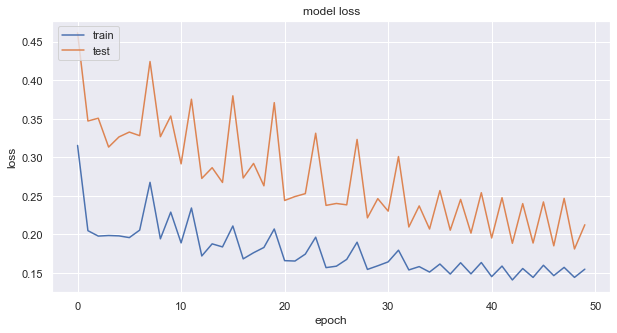

In [12]:
# history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Training loss: 0.33741338405997845


<Figure size 720x360 with 0 Axes>

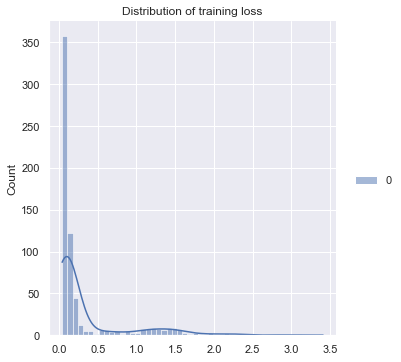

In [14]:
train_pred = model.predict(X_train)
train_loss = (np.mean(np.abs(train_pred - X_train), axis=1))
avg_loss = train_loss.mean()
print('Training loss:', avg_loss)

plt.figure(figsize = (10,5))
sns.displot(train_loss, bins=50, kde=True)
_=plt.title('Distribution of training loss')

In [15]:
# MAE on the test data:
y_pred = model.predict(X_test)
print('Predict shape:', y_pred.shape); print();
mae = np.mean(np.abs(y_pred - X_test), axis=1)
# reshaping prediction
pred = y_pred.reshape((y_pred.shape[0] * y_pred.shape[1]), y_pred.shape[2])
print('Prediction:', pred.shape); print();
print('Test data shape:', X_test.shape); print();
# reshaping test data
X_test = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data:', X_test.shape); print();
# error computation
errors = X_test - pred
print('Error:', errors.shape); print();
# rmse on test data
RMSE = math.sqrt(mean_squared_error(X_test, pred))
print('Test RMSE: %.3f' % RMSE);

Predict shape: (8, 30, 1)

Prediction: (240, 1)

Test data shape: (8, 30, 1)

Test data: (240, 1)

Error: (240, 1)

Test RMSE: 0.985


In [16]:
dist = np.linalg.norm(X_test - pred, axis=1)

scores = dist.copy()
print('Score:', scores.shape)
scores.sort()
cut_off = int(0.80*len(scores))
print('Cutoff value', cut_off)
threshold = scores[cut_off]
print('Threshold value:', threshold)

Score: (240,)
Cutoff value 192
Threshold value: 0.6099376335968691


Text(0.5, 1.0, 'Test & predicted data')

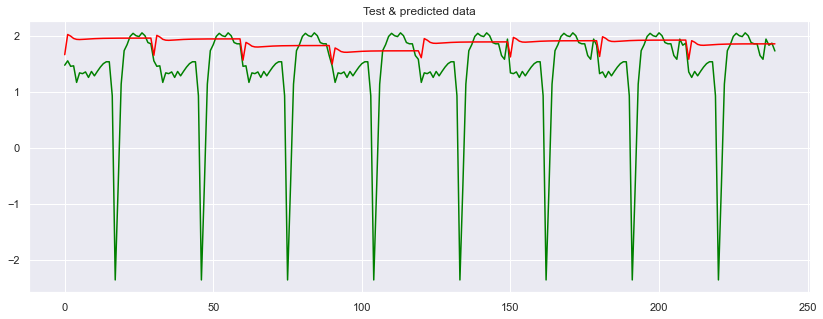

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(X_test, color='green')
plt.plot(pred, color='red')
plt.title('Test & predicted data')

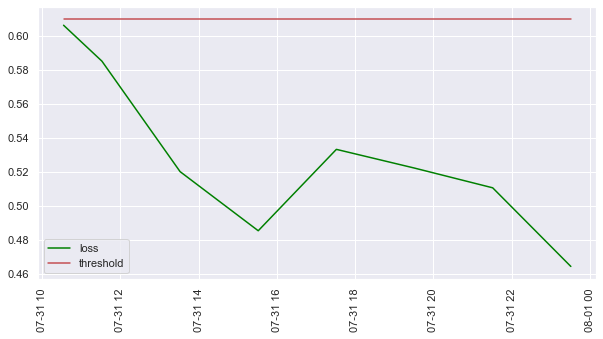

In [18]:
score = pd.DataFrame(index=test[n_steps:].index)
score['loss'] = mae
score['threshold'] = threshold
score['anomaly'] = score['loss'] > score['threshold']
score['HPDIC059'] = test[n_steps:].HPDIC059

plt.figure(figsize=(10,5))
plt.plot(score.index, score['loss'], color='green', label= 'loss')
plt.plot(score.index, score['threshold'], color='r', label='threshold')
plt.xticks(rotation=90)
plt.legend()